# Assignment 7: Bagging and Boosting

Only use the already imported library `numpy`, `matplotlib` and the Python standard library. For the evaluation you may also use scikit-learn (`sklearn`). Make sure that the dataset `titanic.csv` is in the same directory as the notebook.

List your team members (name and immatriculation number) and indicate whether you are a B.Sc. Data Science or other group in the following cell:

Kuang-Yu Li, st169971@stud.uni-stuttgart.de, 3440829
Ya-Jen Hsu, st169013@stud.uni-stuttgart.de, 3449448
Gabriella Ilena, st169935@stud.uni-stuttgart.de, 3440942

In [76]:
# You are allowed to use the numpy package and the DecisionTreeClassifier.
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier


def load_dataset(path):
    import pandas as pd
    from sklearn.model_selection import train_test_split

    df = pd.read_csv('titanic.csv')
    # The feature engineering mostly follows the notebook by Manav Segal: https://www.kaggle.com/startupsci/titanic-data-science-solutions
    # From the Name attribute we can extract titles, which gives insight about the social status/age/gender of the passenger.
    df['Title'] = df['Name'].str.extract(' ([a-zA-Z]+)\.', expand=False)
    df['Title'] = df['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df['Title'] = df['Title'].replace(['Mlle', 'Ms'], 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    # We map the Title attribute to a one-hot encoding.
    df = df.join(pd.get_dummies(df['Title'], prefix='Title'))

    # We map the Sex attribute to a numeric representation.
    df['Sex'] = df['Sex'].map({'female': 1, 'male': 0}).astype(int)

    # We one-hot encode Pclass.
    df = df.join(pd.get_dummies(df['Pclass'], prefix='Pclass'))

    # Based on the number of sibling-spouses in SibSp and parents-childern in Parch, 
    # we can determine whether a passenger was on board alone.
    df['IsAlone'] = ((df['SibSp'] + df['Parch'] + 1) == 1).astype(int)

    # We remove all attributes that do not seem relevant to the prediction, or are already encoded in another attribute.
    df = df.drop(['PassengerId', 'Name', 'Title', 'Ticket', 'Cabin', 'Parch', 'SibSp'], axis=1)

    # For remaining features, we have to separate train and test, 
    # as we will impute missing data based on statistics in the training data.
    df_train, df_test = train_test_split(df, test_size=0.2, random_state=2020)
    # For Embarked, we set all missing values to the most frequent port and then one-hot encode the attribute.
    def impute_embarked():    
        freq_port = df_train['Embarked'].dropna().mode()[0]
        output = []
        for df in (df_train, df_test):
            df = df.join(pd.get_dummies(df['Embarked'].fillna(freq_port), prefix='Embarked'))
            df = df.drop('Embarked', axis=1)
            output.append(df)
        return output

    df_train, df_test = impute_embarked()

    # For Age, we set missing values to the median dependent on the pair of Sex and Pclass.
    guess_ages = np.zeros((2, 3))
    for df in (df_train, df_test):
        for i in range(2):
            for j in range(3):
                guess_ages[i, j] = df[(df['Sex'] == i) & (df['Pclass'] == j+1)]['Age'].dropna().median()
        for i in range(2):
            for j in range(3):
                df.loc[(df['Age'].isnull()) & (df['Sex'] == i) & (df['Pclass'] == j+1), 'Age'] = guess_ages[i, j]
        df['Age'] = df['Age'].astype(int)

    df_train = df_train.drop(['Pclass'], axis=1)
    df_test = df_test.drop(['Pclass'], axis=1)

    X_train = df_train.values[:, 1:]
    X_test = df_test.values[:, 1:]
    y_train = df_train.values[:, 0]
    y_test = df_test.values[:, 0]
    
    return X_train, X_test, y_train, y_test
    
X_train, X_test, y_train, y_test = load_dataset('titanic.csv')

print (X_train.shape)
print (X_train[0])

(712, 15)
[ 0.   20.    7.05  0.    0.    1.    0.    0.    0.    0.    1.    1.
  0.    0.    1.  ]


The Titanic dataset and a description can be found at [Kaggle](https://www.kaggle.com/c/titanic/data). The feature engineering mostly follows the work by [Manav Segal](https://www.kaggle.com/startupsci/titanic-data-science-solutions). 

The prepared dataset contains the following attributes:
- Sex: binary (0 = Male, 1 = Female)
- Age: integer
- Fare: float
- Title_{Master, Miss, Mr, Mrs, Rare}: title of passenger (extracted from name), binary, one-hot encoding of categorical variable Title
- Pclass_{1, 2, 3}: ticket class corresponds to socio-economic status (1 = upper class, 2 = middle class, 3 = lower class), binary, one-hot encoding of categorical variable Pclass
- IsAlone: whether the passenger has no siblings/spouses/parents/children on board, binary
- Embarked_{C, Q, S}: port at which passenger embarked (C = Cherbourg, Q = Queenstown, S = Southampton), binary, one-hot encoding of categorical variable Embarked

The classification target is:
- Survived: binary

Data is split into train-test with a 80-20 ratio yielding 712 training and 179 test samples. Train and test data is stored in the variables `(X_train, y_train)` and `(X_test, y_test)` respectively.

## Task 1: Random Forest

In this task, you will implement a random forest classifier using the scikit-learn implementation of the decision tree. 

Use bootstrap sampling and sample 20% of the original data set for each tree. Randomly select 6 attributes/columns for each trained tree. The prediction of each tree should be weighted equally in the majority vote. Use the already imported class `DecisionTreeClassifier` for your decision trees. You can find the decision tree documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html). You may use either the default parameters or experiment with different settings.

You will evaluate your model on the test data using scikit-learn with the methods shown in the lecture ([precision, recall, F1-score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#sklearn.metrics.precision_recall_fscore_support), [confusion matrices](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html?highlight=confusion%20matrix#sklearn.metrics.confusion_matrix), ...). Try out different number of trees and compare the performance w.r.t. this parameter. Feel free to import any functions you need from scikit-learn for this purpose. 


In [77]:
class RandomForestClassifier(object):
    def __init__(self, number_of_trees):
        self.number_of_trees = number_of_trees
        # Add your code, such as initialization of trees here.

        # Initialize decision tree
        self.trees = list()
        for i in range(self.number_of_trees):
            self.trees.append(DecisionTreeClassifier(criterion='gini', max_features=6))
    
    def bootstrap(self, x_data, y_data, ratio):
        # This function creates a bootstrapped dataset with random samples from the input data
        x_bag = list()
        y_bag = list()
        nx_samples = round(len(x_data) * ratio)
        ny_samples = round(len(y_data) * ratio)
        for x in range(nx_samples):
          index = np.random.randint(0, len(x_data))
          x_bag.append(x_data[index])
        for y in range(ny_samples):
          index = np.random.randint(0, len(y_data))
          y_bag.append(y_data[index])
   
        return x_bag, y_bag

    def fit(self, X, y):
        # Implement your training here.
        # Fit each tree to different bootstrapped dataset
        for i in range(self.number_of_trees):
          x_sample, y_sample = self.bootstrap(X, y, 0.2)
          self.trees[i].fit(x_sample, y_sample)
    
    def predict(self, X):
        # Implement your prediction here.       
        # Get votes for prediction in each tree
        votes = dict()
        for i in range(self.number_of_trees):
          votes[i] = self.trees[i].predict(X)

        # Count the frequency of class prediction for each sample in each tree; the most frequently voted class is the final prediction
        counts = np.array([v for v in votes.values()]) # Change the dictionary to a numpy array
        predictions = list()
        freq = list()
        for item in counts.T: # Transpose to allow access to each sample from all trees
          (unique, counter) = np.unique(item, return_counts=True) # Count the frequency of class occurence in each tree's prediction
          freq.append(counter)
        freq = np.array(freq)

        # Create list of predictions by taking the most frequent class
        for count in freq:
          predictions.append(np.argmax(count))
        predictions = np.array(predictions).astype('float32')

        assert predictions.shape == y_test.shape

        return predictions

In [78]:
# Implement your training and evaluation here.
model = RandomForestClassifier(30)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluating the model
from sklearn.metrics import classification_report, confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Confusion matrix:")
print(conf_matrix)
print("Classification report:")
print(report)

Confusion matrix:
[[101   4]
 [ 71   3]]
Classification report:
              precision    recall  f1-score   support

         0.0       0.59      0.96      0.73       105
         1.0       0.43      0.04      0.07        74

    accuracy                           0.58       179
   macro avg       0.51      0.50      0.40       179
weighted avg       0.52      0.58      0.46       179



## Task 2: Interpreting Random Forests

Implement the mean decrease of accuracy for the [sklearn.ensemble.RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) `forest` to analyse learned attribute importances. Use the test set `X_test` and `y_test` as out-of-bag-samples. Permute the values of the assessed attribute by randomly shuffling the corresponding column. Plot the results to compare the importance of each feature. Discuss your results (are any importance values surprising, do the results make sense in the context of the task, ...).

Note: We have already trained the classifier and stored it in the variable `forest`. You only need to implement MDA and the plots for your results.

Discussion: 
In using precision as a metric for MDA, we can observe that Sex, Title_Mr, Fare, Pclass_1, Title_Master and Pclass_3 are the top 6 attribute related to survival. In these 5 attribute, Sex, Title_Mr and Title_Master are strongly correlated attributes, all of three are sexual type. Moreover, Fare, Pclass_1 and Pclass_3 are also strongly correlated attributes, all of three are indicator of wealthiness. Therefore, we can boldly predict that wealth men have better survival rate. On the other hand, location of embarkment has hardly any relation with survival rate. All three location has the same low MDA.

In [79]:
def create_forest():
    import sklearn.ensemble
    import sklearn.metrics
    forest = sklearn.ensemble.RandomForestClassifier(8)
    forest.fit(X_train, y_train)
    prec, rec, f1, _ = sklearn.metrics.precision_recall_fscore_support(y_test, forest.predict(X_test))
    print('Precision:', prec)
    print('Recall:', rec)
    print('F1-score:', f1)
    return forest

forest = create_forest()

Precision: [0.75409836 0.77192982]
Recall: [0.87619048 0.59459459]
F1-score: [0.81057269 0.67175573]


Sex: 0.06597353497164449
Title_Mr: 0.05582608695652172
Fare: 0.05125486037469063
Pclass_1: 0.028928449161246043
Title_Master: 0.023999999999999952
Pclass_3: 0.018911276069282328
IsAlone: 0.0027826086956521043
Pclass_2: 0.0
Title_Rare: 0.0
Title_Mrs: -0.010869565217391318
Embarked_S: -0.016666666666666805
Embarked_Q: -0.016666666666666805
Embarked_C: -0.016666666666666805
Title_Miss: -0.03140096618357496
Age: -0.07673727238944637


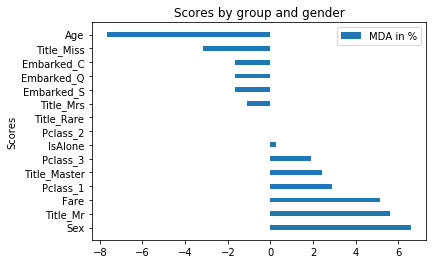

In [86]:
# Implement your solution here.
import sklearn.metrics as sk_metric
import collections

attribute_dict = {
    1: 'Sex',
    2: 'Age',
    3: 'Fare',
    4: 'Title_Master',
    5: 'Title_Miss',
    6: 'Title_Mr',
    7: 'Title_Mrs',
    8: 'Title_Rare',
    9: 'Pclass_1',
    10: 'Pclass_2',
    11: 'Pclass_3',
    12: 'IsAlone',
    13: 'Embarked_C',
    14: 'Embarked_Q',
    15: 'Embarked_S'
}

prec, rec, f1, _ = sk_metric.precision_recall_fscore_support(y_test, forest.predict(X_test))
scores = defaultdict(list)

for i in range(X_test.shape[1]):
    X_t = X_test.copy()
    np.random.shuffle(X_t[:, i])
    shuf_prec, shuf_rec, shuf_f1, shuf_= sk_metric.precision_recall_fscore_support(y_test, forest.predict(X_t))
    acc_dec = (prec[0] - shuf_prec[0]) / prec[0]
    scores[i].append(acc_dec)

# sorted attribute based on accuracy decrease
sorted_scores = sorted(scores.items(), key = lambda kv:(kv[1], kv[0]), reverse=True)
fig_labels = list()
fig_scores = list()
width = 0.35       # the width of the bars
for key in sorted_scores:
    print(attribute_dict[key[0]+1], key[1][0], sep=": ")
    fig_labels.append(attribute_dict[key[0]+1])
    fig_scores.append(key[1][0] * 100)

fig, ax = plt.subplots()
ax.barh(fig_labels, fig_scores, width, label='MDA in %')
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.legend()

plt.show()


## Task 3: Discrete AdaBoost with Decision Stumps
 
*For all students other than B.Sc. Data Science.*  

In this task, you will implement the discrete AdaBoost algorithm using decision stumps as weak learners. Your training will run until either `n_learners` weak learners have been added or a perfect accuracy on the training data set is achieved. Use the function `initialize_decision_stumps` to create decision stumps, which you can train on your weighted data using `fit` and predict using `predict`. The decision stumps are instances of the class [sklearn.tree.DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

In addition, you will evaluate your model on the test data (`X_test`, `y_test`) using scikit-learn with the methods shown in the lecture (precision, recall, F1-score, confusion matrices, ...). Feel free to import any functions you need from scikit-learn for this purpose.

In [55]:
def initialize_decision_stump():
    stump = DecisionTreeClassifier(criterion='entropy', max_depth=1)
    return stump


class AdaBoostClassifier(object):
    def __init__(self, n_learners):
        self.n_learners = n_learners
        # Add any initialization you need here.
        self.stumps = np.zeros(shape=n_learners, dtype=object)
        self.stump_weights = np.zeros(shape=n_learners)
        self.errors = np.zeros(shape=n_learners)

    def fit(self, X, y):
        n_samples = X.shape[0]
        weights = np.zeros(shape=(self.n_learners, n_samples))

        #  Initialize weight to 1/N
        weights[0] = np.ones(shape=n_samples) / n_samples

        for n in range(self.n_learners):
            # Fit weak learner
            current_weights = weights[n]
            stump = initialize_decision_stump()
            stump.fit(X, y, sample_weight= current_weights)

            # Calculate normalized weighted error
            stump_predict = stump.predict(X)
            error = current_weights[stump_predict != y].sum() / n_samples
            stump_weight = np.log((1. -  error) / error)

            # Update weights
            current_weights *= np.exp(-stump_weight  * y * stump_predict)
            if n+1 < self.n_learners:  # Not final iteration
                weights[n+1] = current_weights

            # Save values
            self.stumps[n] = stump
            self.stump_weights[n] = stump_weight
            self.errors[n] = error

    def predict(self, X, y):
        stump_preds = np.array([stump.predict(X) for stump in self.stumps])
        y_ada_pred = np.sign(np.dot(self.stump_weights, stump_preds))
        return y_ada_pred

In [56]:
# Implement your training and evaluation here.  You may reuse the code from Task 1.
myAda = AdaBoostClassifier (10)
myAda.fit(X_test, y_test)
y_ada_pred = myAda.predict(X_test, y_test)

# Evaluating the model
from sklearn.metrics import classification_report, confusion_matrix

conf_matrix = confusion_matrix(y_test, y_ada_pred)
report = classification_report(y_test, y_ada_pred)

print("Confusion matrix:")
print(conf_matrix)
print("Classification report:")
print(report)

Confusion matrix:
[[81 24]
 [20 54]]
Classification report:
              precision    recall  f1-score   support

         0.0       0.80      0.77      0.79       105
         1.0       0.69      0.73      0.71        74

    accuracy                           0.75       179
   macro avg       0.75      0.75      0.75       179
weighted avg       0.76      0.75      0.76       179

